# Algorithm for tracing how the guidewire moves

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quick_plot(data, cmap, centroids=None, movement_vectors=None, title=None, ax=None, centroid_marker="x"):
    if ax is None:
        ax = plt.gca()
    ax.imshow(data, cmap=cmap)
    if centroids:
        centroids_x, centroids_y = zip(*centroids)
        ax.scatter(centroids_x, centroids_y, marker=centroid_marker, color='red')
    if movement_vectors is not None:  # Check if movement_vectors is not None
        for start, end in movement_vectors:
            ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], head_width=2, head_length=2, fc='blue', ec='blue')
    ax.set_title(title)

In [3]:
def find_artifact_centroids(image, gaussian_kernel: int = 7, return_debug_images=False):
    blurred = cv2.GaussianBlur(image, (gaussian_kernel, gaussian_kernel), 0)
    _, thresholded = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    if return_debug_images:
        return blurred, thresholded, centroids
    else:
        return centroids

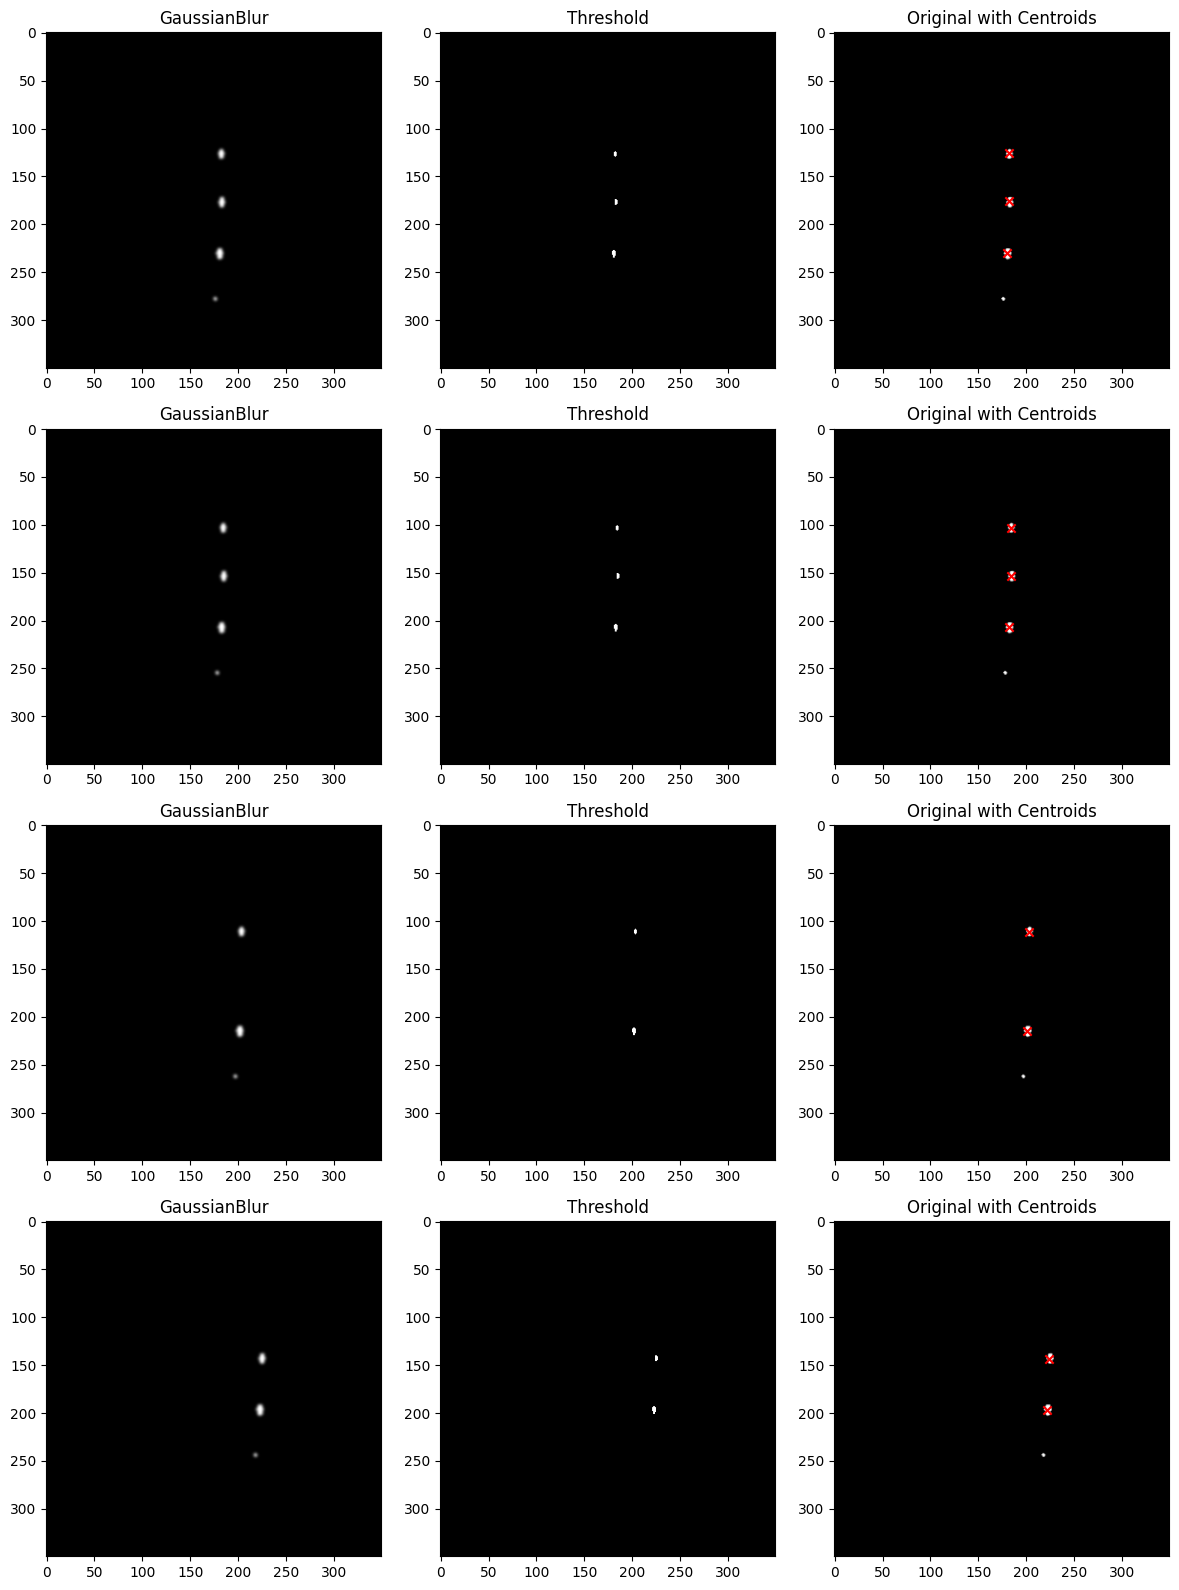

In [4]:
image1 = "guidewire_follow_testdata/1.jpg"
image2 = "guidewire_follow_testdata/2.jpg"
image3 = "guidewire_follow_testdata/3.jpg"
image4 = "guidewire_follow_testdata/4.jpg"
image1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread(image3, cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread(image4, cv2.IMREAD_GRAYSCALE)
images = [image1, image2, image3, image4]

fig, axs = plt.subplots(4, 3, figsize=(12, 16))
for i, image in enumerate(images):
    blurred, thresholded, centroids = find_artifact_centroids(image, return_debug_images=True)
    quick_plot(blurred, 'gray', title="GaussianBlur", ax=axs[i, 0])
    quick_plot(thresholded, 'gray', title="Threshold", ax=axs[i, 1])
    quick_plot(image, 'gray', centroids=centroids, title="Original with Centroids", ax=axs[i, 2])
    
plt.tight_layout()
plt.show()

In [5]:
def get_guidewire_movement_vector(prediction_image, previous_centroids=None):
    """
    Returns moment vectors or None, calculated centroids.
    """
    current_centroids = find_artifact_centroids(prediction_image)
    if previous_centroids is not None:
        movement_vectors = []
        for current_centroid in current_centroids:
            min_dist = float('inf')
            closest_prev_centroid = None
            for prev_centroid in previous_centroids:
                dist = np.linalg.norm(np.array(current_centroid) - np.array(prev_centroid))
                if dist < min_dist:
                    min_dist = dist
                    closest_prev_centroid = prev_centroid
            if closest_prev_centroid:
                movement_vectors.append(((closest_prev_centroid[0], closest_prev_centroid[1]), current_centroid))
        return movement_vectors, current_centroids
    return [], current_centroids

[((180, 230), (182, 207)), ((182, 176), (184, 153)), ((182, 126), (184, 103))]
[((182, 207), (182, 207)), ((184, 153), (184, 153)), ((184, 103), (184, 103))]


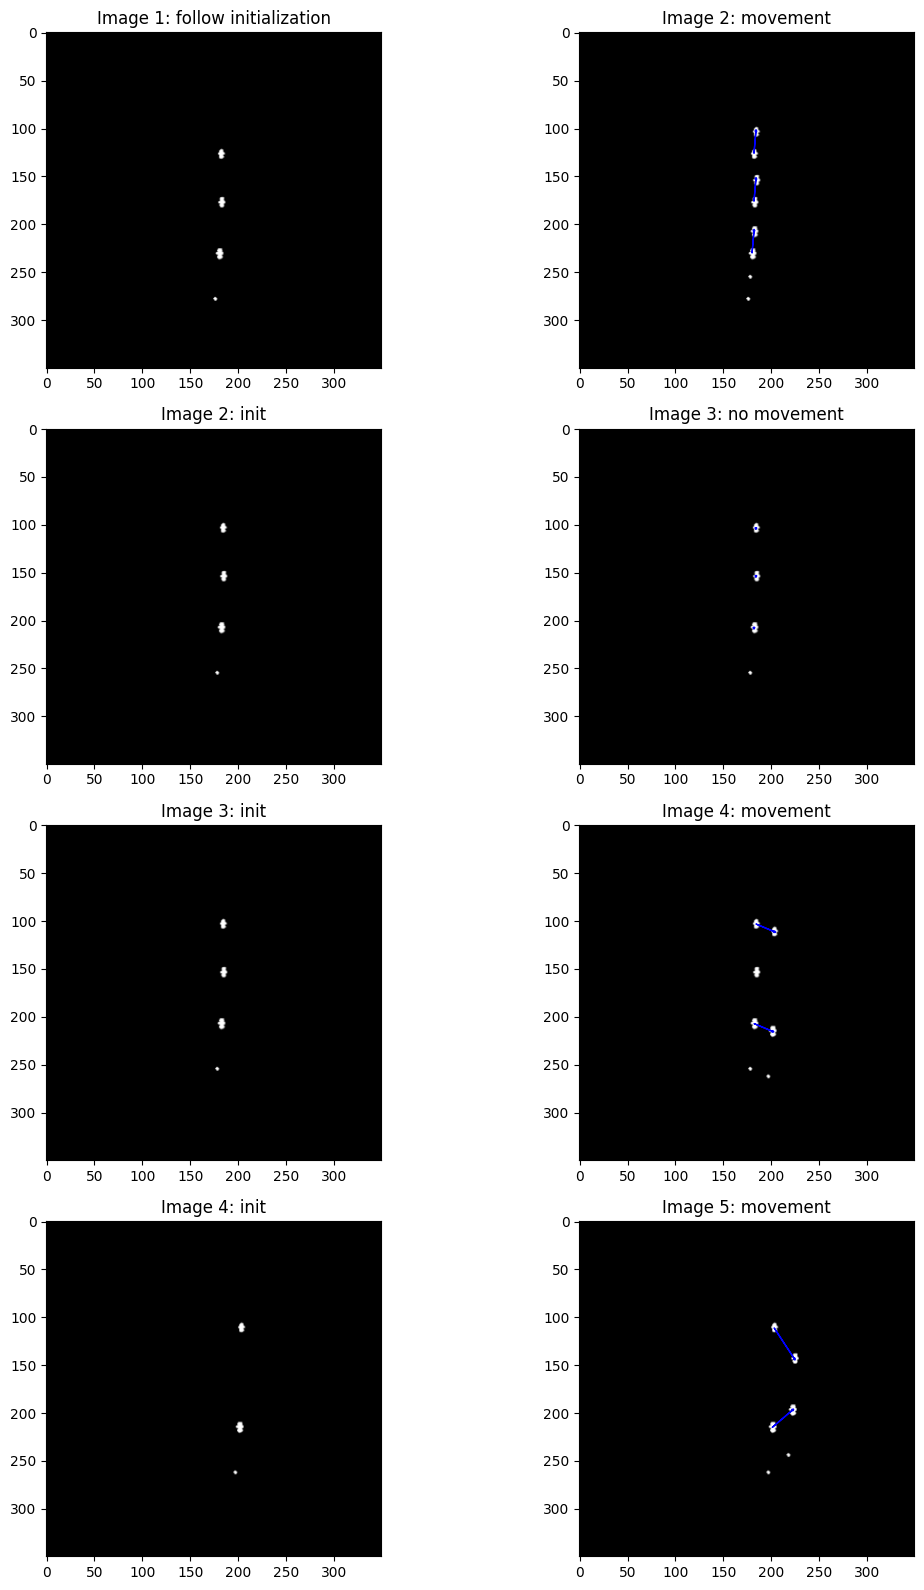

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 16))

_, centroids = get_guidewire_movement_vector(image1)
quick_plot(image1, 'gray', title="Image 1: follow initialization", ax=axs[0, 0])

movement, centroids = get_guidewire_movement_vector(image2, previous_centroids=centroids)
print(movement)
quick_plot(image2+image1, 'gray', movement_vectors=movement, title="Image 2: movement", ax=axs[0, 1])

movement, centroids = get_guidewire_movement_vector(image2, previous_centroids=centroids)
print(movement)
quick_plot(image2, 'gray', title="Image 2: init", ax=axs[1, 0])
quick_plot(image2, 'gray', movement_vectors=movement, title="Image 3: no movement", ax=axs[1, 1])

movement, centroids = get_guidewire_movement_vector(image3, previous_centroids=centroids)
quick_plot(image2, 'gray', title="Image 3: init", ax=axs[2, 0])
quick_plot(image2+image3, 'gray', movement_vectors=movement, title="Image 4: movement", ax=axs[2, 1])


movement, centroids = get_guidewire_movement_vector(image4, previous_centroids=centroids)
quick_plot(image3, 'gray', title="Image 4: init", ax=axs[3, 0])
quick_plot(image3+image4, 'gray', movement_vectors=movement, title="Image 5: movement", ax=axs[3, 1])

plt.tight_layout()
plt.show()
